In [1]:
import numpy as np
import pandas as pd
import math
from collections import deque
from os import listdir
from os.path import isfile, join
from helpers import *

In [2]:
mypath = 'eric_jh_data/'
countries = sorted(['Australia', 'Japan', 'China'])
fx_dict = {'Australia':('eric_jh_data/Forex/AUD_USD_new.csv',0),
           'Japan':('eric_jh_data/Forex/USD_JPY_new.csv',1),
           'China':('eric_jh_data/Forex/USD_HKD_new.csv',1)}

list_pairs = []
for country in countries:
    countrypath = mypath + country
    adr_names =  [f for f in listdir(countrypath) if not isfile(join(countrypath, f))] #grab all adr names of the country
    for adr in sorted(adr_names):
        list_pairs.append((country, adr))
list_pairs_copy = list_pairs.copy()

In [3]:
# date - date in local time
# All dates are in local time: so in sequential order (for each row), it will go stock_open, stock_close, adr_open, adr_close
# avg_bid_non_us_before - how much foreign currency we can buy with 1 USD, 1 minute before the Asian market opens
# avg_ask_non_us_before - how much foreign currency we would need to sell for 1 USD, 1 minute before the Asian market opens
# avg_non_us_before - average of avg_bid_non_us_before and avg_ask_non_us_before
# avg_bid_non_us_at - how much foreign currency we can buy with 1 USD, when the Asian market opens
# avg_ask_non_us_at - how much foreign currency we would need to sell for 1 USD, when the Asian market opens
# avg_non_us_at - average of avg_bid_non_us_at and avg_ask_non_us_at
# avg_bid_us_before - how much foreign currency we can buy with 1 USD, 1 minute before the US market opens
# avg_ask_us_before - how much foreign currency we would need to sell for 1 USD, 1 minute before the US market opens
# avg_us_before - average of avg_bid_us_before and avg_ask_us_before
# avg_bid_us_at - how much foreign currency we can buy with 1 USD, when the US market opens
# avg_ask_us_at - how much foreign currency we would need to sell for 1 USD, when the US market opens
# avg_us_at - average of avg_bid_us_at and avg_ask_us_at
# ir - foreign interest rate
# stock_num_per_unit - how many stocks we would buy for 1 "unit" of trade
# adr_num_per_unit - how many adr shares we would sell for 1 "unit" of trade

merged_df = data_processing(*list_pairs[1], fx_dict)
merged_df.tail()

,date,adr_open,adr_close,adr_volume,stock_open,stock_close,stock_volume,avg_bid_non_us_before,avg_ask_non_us_before,avg_non_us_before,...,avg_bid_us_at,avg_ask_us_at,avg_us_at,ir,stock_num_per_unit,adr_num_per_unit,stock_open_per_unit,stock_close_per_unit,adr_open_per_unit,adr_close_per_unit
1475,2021-03-29,4.23,3.94,203600,0.009,0.0090,2190716,1.308157,1.310810,1.309483,...,1.306976,1.309627,1.308301,0.1,600.0,1,5.4,5.4,4.23,3.94
1476,2021-03-30,3.94,4.14,479400,0.009,0.0095,5387585,1.307797,1.310450,1.309123,...,1.313040,1.315686,1.314363,0.1,600.0,1,5.4,5.7,3.94,4.14
1477,2021-03-31,4.23,4.17,104200,0.009,0.0090,7552944,1.312953,1.315634,1.314294,...,1.312764,1.315426,1.314095,0.1,600.0,1,5.4,5.4,4.23,4.17
1478,2021-04-01,4.30,4.38,208900,0.009,0.0090,1735539,1.315495,1.318163,1.316829,...,1.315408,1.318076,1.316742,0.1,600.0,1,5.4,5.4,4.30,4.38
1479,2021-04-06,4.33,4.19,436900,0.009,0.0110,22378312,1.304654,1.307283,1.305969,...,1.308020,1.310673,1.309346,0.1,600.0,1,5.4,6.6,4.33,4.19


In [4]:
with open('logs/results1_sfx_all.txt') as f:
    res = f.readlines()

In [5]:
variant_df = pd.DataFrame()
variants = ["1", "2", "3a", "3b"]
for variant in variants:
    variant_name = "Variant " + variant
    variant_df[variant_name] = [float(x.split("Return: ")[1].split("%")[0]) for x in res if variant_name in x]
variant_df.mean()

Variant 1     15.393571
Variant 2     22.361786
Variant 3a    22.650357
Variant 3b    23.336429
dtype: float64

We shall choose variant 3b as our final strategy

In [6]:
is_ret = {}
is_hit = {}
index = 0
for (country, adr) in list_pairs:
    is_ret[(country, adr)] = float(res[index*5 + 4].split("Return: ")[1].split("%")[0]) 
    is_hit[(country, adr)] = float(res[index*5 + 4].split("Hit Ratio: ")[1].split("%")[0])
    index += 1

In [7]:
final_df = pd.DataFrame()
final_df["country"] = [x[0] for x in list_pairs]
final_df["adr"] = [x[1] for x in list_pairs]
final_df["is_ret"] = is_ret.values()
final_df["hit_ratio"] = is_hit.values()
final_df = final_df.sort_values(["country","is_ret"], ascending = False)
final_df[(final_df["hit_ratio"] > 55) & (final_df["is_ret"] > 10)]

,country,adr,is_ret,hit_ratio
24,Japan,SMFG_8316,31.18,59.70
20,Japan,IX_8591,27.56,56.90
27,Japan,TM_7203,20.46,68.97
21,Japan,MFG_8411,15.92,60.71
10,China,BGNE_6160,78.06,74.42
16,China,SNP_386,55.54,59.09
12,China,HNP_902,33.78,59.84
11,China,CEA_670,17.93,62.83
9,China,ACH_2600,14.02,61.02
6,Australia,MESO_MSB,84.63,80.23


In [8]:
# Pairs we have chosen to trade
list_pairs = [("Japan", "SMFG_8316"), 
              ("Japan", "IX_8591"),
              ("Japan", "TM_7203"),
              ("Japan", "MFG_8411"),
              ("China", "BGNE_6160"), 
              ("China", "SNP_386"), 
              ("China", "HNP_902"), 
              ("China", "CEA_670"),
              ("China", "ACH_2600"),
              ("Australia", "MESO_MSB"),
              ("Australia", "IMMP_IMM"),
              ("Australia", "PLL_PLL"),
              ("Australia", "KZIA_KZA"),
              ("Australia", "IMRN_IMC")]

# Final Strategy

In [9]:
hp = {}
for i in range(len(list_pairs_copy)):
    hp[list_pairs_copy[i]] = [float(x) for x in res[i*5 + 4].split("(")[1].split(")")[0].split(", ")]

df_dict = {}
for (country, adr) in list_pairs_copy:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
date_set = set()
for (country, adr) in list_pairs_copy:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
date_set.add("2015-04-08")
datelist = sorted(date_set)

In [10]:
def final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, cash = 250000, 
                   start_date = "2016-01-01", end_date = "2021-01-31", slippage_bps = 10, borrowing_bps = 50, 
                   risk_lookback = 100, cooldown_limit = 100, var_ci = 0.95, var_limit = 0.1, 
                   max_drawdown_limit = 0.2, sigma_limit = 0.05, stop_loss_limit = 0.15, maximum_holding_period = 30, 
                   volume_lookback = 5, adjust_for_risk = True):

    # Number of pairs from each country we will trade at each time
    num_traded = {"Australia" : [], "China" : [], "Japan" : []}

    hp_dict = {}
    for (country, adr) in list_pairs:
        hp_dict[(country, adr)] = {}
        hp_dict[(country, adr)]["lookback"] = int(hp[(country, adr)][0])
        hp_dict[(country, adr)]["entry"] = hp[(country, adr)][1]
        hp_dict[(country, adr)]["exit"] = hp[(country, adr)][2]
        hp_dict[(country, adr)]["actual_entries"] = []
        hp_dict[(country, adr)]["actual_exits"] = []
        hp_dict[(country, adr)]["stop_loss"] = hp[(country, adr)][3]
        # Fraction of cash allocated to each adr-stock pair
        hp_dict[(country, adr)]["allocation"] = allocation[country]/trading_limits[country]
        hp_dict[(country, adr)]["original_allocation"] = allocation[country]/trading_limits[country]

    diff_record_dict = {}
    for (country, adr) in list_pairs:
        diff_record_dict[(country, adr)] = deque(maxlen = 2*hp_dict[(country, adr)]["lookback"])

    conditions = {}
    for (country, adr) in list_pairs:
        conditions[(country, adr)] = {}
        conditions[(country, adr)]["enter_cond1"] = False
        conditions[(country, adr)]["exit_cond1"] = False
        conditions[(country, adr)]["enter_cond2"] = False
        conditions[(country, adr)]["exit_cond2"] = False

    iter_dict = {}
    for (country, adr) in list_pairs:
        iter_dict[(country, adr)] = {}
        iter_dict[(country, adr)]["index"] = 0

    positions = {}
    for (country, adr) in list_pairs:
        positions[(country, adr)] = {}
        positions[(country, adr)]["stock_pos"] = 0
        positions[(country, adr)]["adr_pos"] = 0
        positions[(country, adr)]["prev_adr_pos"] = 0
        positions[(country, adr)]["holding_period"] = None
        positions[(country, adr)]["trade_type"] = None

    forex_dict = {}
    for (country, adr) in list_pairs:
        forex_dict[(country, adr)] = {}
        forex_dict[(country, adr)]["forex_cash"] = 0
        forex_dict[(country, adr)]["prev_forex_value"] = 0

    trade_records = []
    portfolio_values = []
    portfolio_values_for_risk = []
    dates = []
    # Determine if risk limits have been breached
    breach1 = False
    breach2 = False
    cooldown = cooldown_limit
    reduced_allocation_cooldown = cooldown_limit
    
    # Accounts for slippage and transaction costs
    short_multiplier = 1 - 0.0001*slippage_bps
    long_multiplier = 1 + 0.0001*slippage_bps
    starting_cash = cash
    # For book-keeping, since we shall store the portfolio value of the day before
    prev_cash = cash
    
    for i in range(1, len(datelist)):
        current_date = datelist[i]
        prev_date = datelist[i-1]
        if current_date >= start_date and prev_date <= end_date:
            # Log number of stocks traded in each country
            # Log portfolio value of the day before, when the Asian market opens
            cooldown += 1
            reduced_allocation_cooldown += 1
            dates.append(prev_date)
            prev_value = prev_cash
            for country in countries:
                num_traded[country].append(0)
            for (country, adr) in list_pairs:
                index = iter_dict[(country, adr)]["index"]
                merged_df = df_dict[(country, adr)]
                row = merged_df.loc[index]
                if positions[(country, adr)]["stock_pos"] > 0:
                    num_traded[country][-1] += 1
                if index > 0:
                    # Add adr values
                    prev_value += positions[(country, adr)]["prev_adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                    # Add stock values
                    forex_dict[(country, adr)]["prev_forex_value"] = forex_dict[(country, adr)]["forex_cash"] 
                    forex_dict[(country, adr)]["prev_forex_value"] += positions[(country, adr)]["stock_pos"]*row['stock_open']
                    if forex_dict[(country, adr)]["prev_forex_value"] > 0:
                        # For our convention, ask price is the price of selling foreign currency (how much foreign currency to sell for 1 USD)
                        # Ask price > Bid price
                        forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_ask_non_us_at']
                    elif forex_dict[(country, adr)]["prev_forex_value"] < 0:
                        forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_bid_non_us_at']
                    prev_value += forex_dict[(country, adr)]["prev_forex_value"]
            portfolio_values.append(prev_value)
            portfolio_values_for_risk.append(prev_value)

            # Account for borrowing cost
            for (country, adr) in list_pairs:
                index = iter_dict[(country, adr)]["index"]
                merged_df = df_dict[(country, adr)]
                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                if positions[(country, adr)]["stock_pos"] > 0:
                    positions[(country, adr)]["holding_period"] += 1
                    # Cost of shorting stock
                    cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
                    # Cost of shorting cash
                    multiplier = (1 + 0.01*(2 + merged_df.loc[index]["ir"])*(1/252))
                    forex_dict[(country, adr)]["forex_cash"] *= multiplier
            prev_cash = cash

            # Risk Tests
            if reduced_allocation_cooldown == cooldown_limit:
                for (country, adr) in list_pairs:
                    hp_dict[(country, adr)]["allocation"] = hp_dict[(country, adr)]["original_allocation"]
            
            if cooldown >= cooldown_limit and adjust_for_risk:
                max_drawdown = calc_max_drawdown(portfolio_values_for_risk, method = "absolute")
                starting_cash = portfolio_values_for_risk[0]
                cum_pl = prev_value - starting_cash
                # Fraction to liquidate
                liquidate_frac = 0
                # If max drawdown / cum PnL hits 50% or 75% of limit
                # Liquidate a fraction of positions and reduce the amount traded for future transactions
                # If max drawdown / cum PnL hits 100% of limit
                # Liquidate all positions, stop trading for {cooldown} days, reset all risk measures
                if max_drawdown > max_drawdown_limit*starting_cash or cum_pl < -stop_loss_limit*starting_cash:
                    liquidate_frac = 1
                    cooldown = 0
                    portfolio_values_for_risk = []
                    breach1 = False
                    breach2 = False
                    # Return to original allocation after cooldown.
                    # In real-life, someone would step in and redecide if this is appropriate
                    for (country, adr) in list_pairs:
                        hp_dict[(country, adr)]["allocation"] = hp_dict[(country, adr)]["original_allocation"]
                elif (max_drawdown > 0.75*max_drawdown_limit*starting_cash or cum_pl < -0.75*stop_loss_limit*starting_cash) and not breach2:
                    liquidate_frac = 0.5
                    for (country, adr) in list_pairs:
                        hp_dict[(country, adr)]["allocation"] = hp_dict[(country, adr)]["original_allocation"]*(1/3)
                    breach2 = True
                    reduced_allocation_cooldown = 0
                elif (max_drawdown > 0.5*max_drawdown_limit*starting_cash or cum_pl < -0.5*stop_loss_limit*starting_cash) and not breach1:
                    liquidate_frac = 1/3
                    for (country, adr) in list_pairs:
                        hp_dict[(country, adr)]["allocation"] = hp_dict[(country, adr)]["original_allocation"]*(1/2)
                    breach1 = True
                    reduced_allocation_cooldown = 0

                # Calculate VaR and PnL volatility for each prior day at Asian market open
                # Further adjust fraction to liquidate based on these risk limits
                stock_values = np.zeros(risk_lookback)
                adr_values = np.zeros(risk_lookback)
                for (country, adr) in list_pairs:
                    index = iter_dict[(country, adr)]["index"]
                    merged_df = df_dict[(country, adr)]
                    if index > 0:
                        temp_risk_lookback = min(risk_lookback, index)
                        current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                        ind_stock_values = (np.array(current["stock_open"])/np.array(current["avg_non_us_at"]))*positions[(country, adr)]["stock_pos"] 
                        ind_adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*positions[(country, adr)]["adr_pos"])
                        stock_values[-len(ind_stock_values):] += ind_stock_values
                        adr_values[-len(ind_adr_values):] += ind_adr_values
                sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                if sigma > prev_value*sigma_limit:
                    new_liquidate_frac = (sigma - prev_value*sigma_limit)/(prev_value*sigma_limit)
                    liquidate_frac = max(liquidate_frac, new_liquidate_frac)

                if var > prev_value*var_limit:
                    new_liquidate_frac = (var - prev_value*var_limit)/(prev_value*var_limit)
                    liquidate_frac = max(liquidate_frac, new_liquidate_frac)

                # Liquidate if necessary
                if liquidate_frac > 0:
                    for (country, adr) in list_pairs:
                        index = iter_dict[(country, adr)]["index"]
                        merged_df = df_dict[(country, adr)]
                        if index > 0 and index+1 < len(merged_df):
                            row = merged_df.loc[index]
                            stock_pos = positions[(country, adr)]["stock_pos"]
                            adr_pos = positions[(country, adr)]["adr_pos"]
                            if stock_pos > 0:
                                units_traded = stock_pos/row["stock_num_per_unit"]
                                units_liquidated = math.ceil(units_traded*liquidate_frac)
                                stock_quantity_sold = int(units_liquidated*row["stock_num_per_unit"])
                                adr_quantity_bought = int(units_liquidated*row["adr_num_per_unit"])
                                adr_px = row['adr_open']*long_multiplier
                                cash -= adr_quantity_bought*adr_px
                                prev_cash -= adr_quantity_bought*adr_px

                                stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                                leftover_forex_cash = forex_dict[(country, adr)]["forex_cash"]*liquidate_frac
                                leftover_forex_cash += stock_px_fx*stock_quantity_sold
                                forex_dict[(country, adr)]["forex_cash"] *= (1-liquidate_frac)
                                if leftover_forex_cash > 0:
                                    leftover_forex_cash /= merged_df.loc[index+1,'avg_ask_non_us_at']
                                else:
                                    leftover_forex_cash /= merged_df.loc[index+1,'avg_bid_non_us_at']
                                cash += leftover_forex_cash
                                prev_cash += leftover_forex_cash

                                trade_records.append("Liquidating positions:\n")
                                # Times in EST
                                trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                                positions[(country, adr)]["adr_pos"] += adr_quantity_bought
                                positions[(country, adr)]["stock_pos"] -= stock_quantity_sold
                                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                if liquidate_frac == 1:
                                    positions[(country, adr)]["holding_period"] = None
                                    num_traded[country][-1] += 1

        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            # Lookback parameter is in number of trading days
            lookback = 2*hp_dict[(country, adr)]["lookback"]

            if index+1 < len(merged_df):
                row = merged_df.loc[index]
                if row["date"] == current_date:
                    iter_dict[(country, adr)]["index"] += 1
                    if index > 0: 
                        diff_record = diff_record_dict[(country, adr)]
                        entry = hp_dict[(country, adr)]["entry"]
                        exit = hp_dict[(country, adr)]["exit"]
                        stop_loss = hp_dict[(country, adr)]["stop_loss"]
                        stock_pos = positions[(country, adr)]["stock_pos"]
                        adr_pos = positions[(country, adr)]["adr_pos"]
                        holding_period = positions[(country, adr)]["holding_period"]
                        trade_type = positions[(country, adr)]["trade_type"]
                        stock_name = adr.split("_")[1]
                        adr_name = adr.split("_")[0]
                        enter_cond1 = conditions[(country, adr)]["enter_cond1"]
                        exit_cond1 = conditions[(country, adr)]["exit_cond1"]
                        enter_cond2 = conditions[(country, adr)]["enter_cond2"]
                        exit_cond2 = conditions[(country, adr)]["exit_cond2"]

                        # Before the US Market open, append price difference between ADR and stock
                        diff_record.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_us_before'])
                        if len(diff_record) == lookback and row["date"] >= start_date and row["date"] <= end_date and cooldown >= cooldown_limit:
                            mean = np.array(diff_record).mean()
                            std = np.array(diff_record).std()
                            
                            # Check that a concurrent trade was not already placed
                            if not (enter_cond2 or exit_cond2):
                                enter_cond1 = (diff_record[-1] > mean + entry*std
                                               and diff_record[-1] <= mean + stop_loss*std
                                               and stock_pos == 0 and adr_pos == 0 
                                               and num_traded[country][-1] < trading_limits[country])
                                exit_cond1 = ((diff_record[-1] < mean + exit*std
                                              or diff_record[-1] > mean + stop_loss*std
                                              or (holding_period == maximum_holding_period and trade_type == 1))
                                              and stock_pos > 0 and adr_pos < 0)

                                if enter_cond1:
                                    portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                                    # Allow ourselves to trade 20% of ADT volume over the past 5 trading days
                                    # We take the median to make this estimate more robust to extreme values
                                    adr_volume = 0.1*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].median()/row["adr_num_per_unit"])
                                    stock_volume = 0.1*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                                    units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                                    (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_us_before']), 
                                                    adr_volume, 
                                                    stock_volume))
                                    adr_quantity = int(units*row["adr_num_per_unit"])
                                    stock_quantity = int(units*row["stock_num_per_unit"])

                                    # Take portfolio value for each previous day when the US market opens
                                    # Further adjust volume based on historical max drawdown, VaR and PnL volatility
                                    temp_risk_lookback = min(risk_lookback, index)
                                    current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                                    stock_values = np.array((current["stock_close"]/current["avg_us_before"])*stock_quantity) 
                                    adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                                    if (var > portfolio_value_before_entering*var_limit*(allocation[country]) or 
                                        max_drawdown_abs > max_drawdown_limit*starting_cash*(allocation[country]) or 
                                        sigma > portfolio_value_before_entering*sigma_limit*(allocation[country])):
                                        frac = min((portfolio_value_before_entering*var_limit*(allocation[country]))/var, 
                                                   (max_drawdown_limit*starting_cash*(1/trading_limits[country]))/max_drawdown_abs,
                                                  (portfolio_value_before_entering*sigma_limit*(allocation[country]))/sigma)
                                        units = int(frac*units)
                                        if units == 0:
                                            enter_cond1 = False
                                        adr_quantity = int(units*row["adr_num_per_unit"])
                                        stock_quantity = int(units*row["stock_num_per_unit"]) 
                                        
                                    if units != 0:
                                        # Short ADR
                                        adr_pos -= adr_quantity
                                        positions[(country, adr)]["adr_pos"] -= adr_quantity
                                        adr_px = row['adr_open']*short_multiplier
                                        cash += adr_quantity*adr_px
                                        prev_cash += adr_quantity*adr_px
                                        actual_price_difference = row['adr_open_per_unit'] - row['stock_close_per_unit']/row['avg_us_before']
                                        actual_entry = (actual_price_difference - mean)/std
                                        hp_dict[(country, adr)]["actual_entries"].append(actual_entry)
                                        
                                        # Long Stock
                                        stock_pos += stock_quantity
                                        positions[(country, adr)]["stock_pos"] += stock_quantity
                                        stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                        forex_dict[(country, adr)]["forex_cash"] -= stock_px_fx*stock_quantity

                                        positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                        positions[(country, adr)]["holding_period"] = 0
                                        positions[(country, adr)]["trade_type"] = 1
                                        num_traded[country][-1] += 1

                                        trade_records.append("Opening positions:\n")
                                        # Times in EST
                                        trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                        trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                                elif exit_cond1:
                                    # Long ADR
                                    adr_px = row['adr_open']*long_multiplier
                                    cash -= abs(adr_pos)*adr_px
                                    prev_cash -= abs(adr_pos)*adr_px
                                    actual_price_difference = row['adr_open_per_unit'] - row['stock_close_per_unit']/row['avg_us_before']
                                    actual_exit = (actual_price_difference - mean)/std
                                    hp_dict[(country, adr)]["actual_exits"].append(actual_exit)
                                    
                                    # Short Stock
                                    stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                                    forex_dict[(country, adr)]["forex_cash"] += stock_px_fx*stock_pos
                                    if forex_dict[(country, adr)]["forex_cash"] > 0:
                                        forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_ask_non_us_at']
                                    else:
                                        forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_bid_non_us_at']
                                    cash += forex_dict[(country, adr)]["forex_cash"]
                                    prev_cash += forex_dict[(country, adr)]["forex_cash"]
                                    forex_dict[(country, adr)]["forex_cash"] = 0

                                    trade_records.append("Closing positions:\n")
                                    # Times in EST
                                    trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                    trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                                    positions[(country, adr)]["stock_pos"] = 0
                                    positions[(country, adr)]["adr_pos"] = 0
                                    positions[(country, adr)]["holding_period"] = None
                                    positions[(country, adr)]["trade_type"] = None
                                    positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                    num_traded[country][-1] -= 1

                                conditions[(country, adr)]["enter_cond1"] = enter_cond1
                                conditions[(country, adr)]["exit_cond1"] = exit_cond1

                        # Before the Asian Market open, append price difference between ADR and stock
                        diff_record.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before'])
                        if len(diff_record) == lookback and row["date"] >= start_date and merged_df.loc[index+1,"date"] <= end_date:
                            mean = np.array(diff_record).mean()
                            std = np.array(diff_record).std()

                            # Check that a concurrent trade was not already placed
                            if not (enter_cond1 or exit_cond1):
                                enter_cond2 = (diff_record[-1] > mean + entry*std
                                               and diff_record[-1] <= mean + stop_loss*std
                                               and stock_pos == 0 and adr_pos == 0 
                                               and num_traded[country][-1] < trading_limits[country])
                                exit_cond2 = ((diff_record[-1] < mean + exit*std
                                              or diff_record[-1] > mean + stop_loss*std
                                              or (holding_period == maximum_holding_period and trade_type == 2))
                                              and stock_pos > 0 and adr_pos < 0)

                                if enter_cond2:
                                    # Allow ourselves to trade 20% of ADT volume over the past 5 trading days
                                    # We take the median to make this estimate more robust to extreme values
                                    portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                                    adr_volume = 0.1*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].median()/row["adr_num_per_unit"])
                                    stock_volume = 0.1*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                                    units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/row['adr_close_per_unit'],
                                                    (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before']), 
                                                    adr_volume, 
                                                    stock_volume))
                                    adr_quantity = int(units*row["adr_num_per_unit"])
                                    stock_quantity = int(units*row["stock_num_per_unit"])

                                    # Take portfolio value for each previous day when the Asian market opens
                                    # Further adjust volume based on historical Max Drawdown, VaR and PnL volatility
                                    temp_risk_lookback = min(risk_lookback, index)
                                    current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                                    next_day = merged_df.loc[(index - temp_risk_lookback + 2):(index + 1)].copy()
                                    stock_values = (np.array((current["stock_close"])/np.array(next_day["avg_non_us_before"]))*stock_quantity) 
                                    adr_values = np.array(current["adr_close"]*adr_quantity)
                                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                                    if (var > portfolio_value_before_entering*var_limit*(allocation[country]) or 
                                        max_drawdown_abs > max_drawdown_limit*starting_cash*(allocation[country]) or 
                                        sigma > portfolio_value_before_entering*sigma_limit*(allocation[country])):
                                        frac = min((portfolio_value_before_entering*var_limit*(allocation[country]))/var, 
                                                   (max_drawdown_limit*starting_cash*(allocation[country]))/max_drawdown_abs,
                                                  (portfolio_value_before_entering*sigma_limit*(allocation[country]))/sigma)
                                        units = int(frac*units)
                                        if units == 0:
                                            enter_cond2 = False
                                        adr_quantity = int(units*row["adr_num_per_unit"])
                                        stock_quantity = int(units*row["stock_num_per_unit"])   
                                    if units != 0:
                                        # Long stock
                                        stock_pos += stock_quantity
                                        positions[(country, adr)]["stock_pos"] += stock_quantity
                                        stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                        forex_dict[(country, adr)]["forex_cash"] -= stock_px_fx*stock_quantity
                                        # We store the current cash/adr position for book-keeping purposes, 
                                        # because the trade below will occur on the next day (EST)
                                        positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                        
                                        actual_price_difference = row['adr_close_per_unit'] - merged_df.loc[index+1,'stock_open_per_unit']/merged_df.loc[index+1,'avg_non_us_before']
                                        actual_entry = (actual_price_difference - mean)/std
                                        hp_dict[(country, adr)]["actual_entries"].append(actual_entry)
                                        
                                        # Short ADR
                                        adr_pos -= adr_quantity
                                        positions[(country, adr)]["adr_pos"] -= adr_quantity
                                        adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                                        cash += adr_quantity*adr_px

                                        positions[(country, adr)]["holding_period"] = 0
                                        positions[(country, adr)]["trade_type"] = 2
                                        num_traded[country][-1] += 1
                                        trade_records.append("Opening positions:\n")
                                        # Times in EST
                                        trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                                        trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                                # Liquidation condition
                                elif exit_cond2:
                                    # Short stock
                                    stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                                    forex_dict[(country, adr)]["forex_cash"] += stock_px_fx*stock_pos
                                    if forex_dict[(country, adr)]["forex_cash"] > 0:
                                        forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_ask_non_us_at']
                                    else:
                                        forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_bid_non_us_at']
                                    cash += forex_dict[(country, adr)]["forex_cash"]
                                    prev_cash += forex_dict[(country, adr)]["forex_cash"]
                                    forex_dict[(country, adr)]["forex_cash"] = 0
                                    # We store the current cash/adr position for book-keeping purposes, 
                                    # because the trade below will occur on the next day (EST)
                                    positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                    
                                    actual_price_difference = row['adr_close_per_unit'] - merged_df.loc[index+1,'stock_open_per_unit']/merged_df.loc[index+1,'avg_non_us_before']
                                    actual_exit = (actual_price_difference - mean)/std
                                    hp_dict[(country, adr)]["actual_exits"].append(actual_exit)
                                    
                                    # Long ADR
                                    adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                                    cash -= abs(adr_pos)*adr_px
                                    trade_records.append("Closing positions:\n")
                                    # Times in EST
                                    trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                                    trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                                    positions[(country, adr)]["stock_pos"] = 0
                                    positions[(country, adr)]["adr_pos"] = 0
                                    positions[(country, adr)]["holding_period"] = None
                                    positions[(country, adr)]["trade_type"] = None
                                    num_traded[country][-1] -= 1

                                conditions[(country, adr)]["enter_cond2"] = enter_cond2
                                conditions[(country, adr)]["exit_cond2"] = exit_cond2

    return dates, portfolio_values, trade_records, num_traded, hp_dict

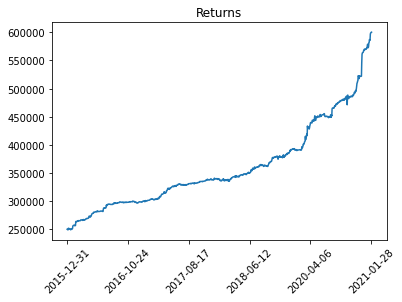

Returns: 140.09%
Sharpe Ratio: 3.28


In [11]:
trading_limits = {"Australia" : 5, "China" : 5, "Japan" : 4}
allocation = {"Australia" : 1/3, "China" : 1/3, "Japan" : 1/3}
# In-Sample
dates1, portfolio_values1, trade_records1, num_traded1, hp_dict1 = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2016-01-01", end_date = "2019-02-21")
dates2, portfolio_values2, trade_records2, num_traded2, hp_dict2 = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2020-02-23", end_date = "2021-01-31", cash = portfolio_values1[-1])
plt.title("Returns")
dates = dates1 + dates2[1:]
portfolio_values = portfolio_values1 + portfolio_values2[1:]
plot_returns(dates, portfolio_values)
#print("".join(trade_records[:11]))
ret = np.round(100*(portfolio_values[-1] - portfolio_values[0])/portfolio_values[0], 2)
print("Returns: {}%".format(ret))
print("Sharpe Ratio: {}".format(calc_sharpe(portfolio_values)))

In [12]:
num_traded_aus = num_traded1["Australia"] + num_traded2["Australia"]
num_traded_hk = num_traded1["China"] + num_traded2["China"]
num_traded_jpn = num_traded1["Japan"] + num_traded2["Japan"]
pd.DataFrame(data = np.c_[np.arange(1, 6), np.array(list(map(lambda x : np.mean(np.array(num_traded_aus) <= x), np.arange(1, 6))))], 
             columns = ["$x$", "Proportion of Time we Trade $x$ or fewer Australian stocks"]).set_index("$x$")

,Proportion of Time we Trade $x$ or fewer Australian stocks
$x$,
1.0,0.755837
2.0,0.949416
3.0,0.981518
4.0,0.996109
5.0,1.000000


In [13]:
pd.DataFrame(data = np.c_[np.arange(1, 6), np.array(list(map(lambda x : np.mean(np.array(num_traded_hk) <= x), np.arange(1, 6))))], 
             columns = ["$x$", "Proportion of Time we Trade $x$ or fewer Chinese stocks"]).set_index("$x$")

,Proportion of Time we Trade $x$ or fewer Chinese stocks
$x$,
1.0,0.635214
2.0,0.882296
3.0,0.978599
4.0,0.997082
5.0,1.000000


In [14]:
pd.DataFrame(data = np.c_[np.arange(1, 5), np.array(list(map(lambda x : np.mean(np.array(num_traded_jpn) <= x), np.arange(1, 5))))], 
             columns = ["$x$", "Proportion of Time we Trade $x$ or fewer Japanese stocks"]).set_index("$x$")

,Proportion of Time we Trade $x$ or fewer Japanese stocks
$x$,
1.0,0.871595
2.0,0.964008
3.0,0.996109
4.0,1.000000


# Hyperparameter Tuning for Allocation

In [9]:
import itertools
from joblib import Parallel, delayed

aus_grid = [2,3]
china_grid = [2,3,4]
japan_grid = [2,3,4]
tls = list(itertools.product(*[aus_grid, china_grid, japan_grid]))

allocs = []

for i in range(20,51, 5):
    for j in range(20, 51, 5):
        for k in range(20, 51, 5):
            if i + j + k == 100:
                allocs.append((i / 100, j / 100, k / 100))

In [11]:
def hp_tune(al):
    for tl in tls:
        trading_limits = {"Australia" : tl[0], "China" : tl[1], "Japan" : tl[2]}
        allocation = {"Australia" : al[0], "China" : al[1], "Japan" : al[2]}
        pv1 = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2016-01-01", end_date = "2019-02-21")[1]
        pv2 = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2020-02-23", end_date = "2021-01-31", cash = pv1[-1])[1]
        ret = np.round(100*(pv2[-1] - pv1[0])/pv1[0], 2)
        
        fname = 'logs/port_alloc_hp_tune.txt'
        f = open(fname, 'a')
        f.writelines(f'Returns: {ret}%, Trading Limits: {tl}, Allocation: {al}\n')
        f.close()

In [12]:
pa = Parallel(n_jobs=-1, verbose = 10)(delayed(hp_tune)(al) for al in allocs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  36 | elapsed: 27.8min remaining: 83.5min
[Parallel(n_jobs=-1)]: Done  13 out of  36 | elapsed: 28.0min remaining: 49.5min
[Parallel(n_jobs=-1)]: Done  17 out of  36 | elapsed: 53.5min remaining: 59.8min
[Parallel(n_jobs=-1)]: Done  21 out of  36 | elapsed: 53.8min remaining: 38.5min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed: 55.1min remaining: 24.2min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 55.5min remaining: 13.4min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 65.0min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 65.2min finished


In [13]:
def sort_res(string):
    end = string.find('%')
    return float(string[9:end])

def sort_results(fname):
    f = open(fname, 'r')
    res = f.readlines()
    f.close()
    sorted_res = sorted(res, key = sort_res, reverse = True)
    f = open(fname, 'w')
    f.writelines(sorted_res)
    f.close()

In [14]:
sort_results('logs/port_alloc_hp_tune.txt')

In [17]:
fname = 'logs/port_alloc_hp_tune.txt'
f = open(fname, 'r')
res = f.readlines()
f.close()
res = res[:35]

def oos_res(r):
    tl_ind = r.find('Limits: ')
    al_ind = r.find(', Allocation: ')
    tl = tuple(map(float, r[tl_ind + 9:al_ind - 1].split(', ')))
    al = tuple(map(float, r[al_ind + 15:-2].split(', ')))
    trading_limits = {"Australia" : tl[0], "China" : tl[1], "Japan" : tl[2]}
    allocation = {"Australia" : al[0], "China" : al[1], "Japan" : al[2]}
    fname = 'logs/port_alloc_hps_oos.txt'
    is_pv1 = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2016-01-01", end_date = "2019-02-21")[1]
    is_pv2 = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2020-02-23", end_date = "2021-01-31", cash = is_pv1[-1])[1]
    is_ret = np.round(100*(is_pv2[-1] - is_pv1[0])/is_pv1[0], 2)
    is_sr = calc_sharpe(is_pv1 + is_pv2)
    oos_pv = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2019-02-22", end_date = "2020-02-21")[1]
    oos_sr = calc_sharpe(oos_pv)
    oos_ret = np.round(100*(oos_pv[-1] - oos_pv[0])/oos_pv[0], 2)
    st_pv = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2020-03-01", end_date = "2020-03-31")[1]
    st_sr = calc_sharpe(st_pv)
    st_ret = np.round(100*(st_pv[-1] - st_pv[0])/st_pv[0], 2)
    tot_pv = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2016-01-01", end_date = "2021-01-31")[1]
    tot_sr = calc_sharpe(tot_pv)
    tot_ret = np.round(100*(tot_pv[-1] - tot_pv[0])/tot_pv[0], 2)
    string = f'Trading Limits: {tl}, Allocation: {al}\n'
    string += f'IS: Return = {is_ret}%, Sharpe Ratio = {is_sr}\n'
    string += f'OOS: Return = {oos_ret}%, Sharpe Ratio = {oos_sr}\n'
    string += f'Stress Testing: Return = {st_ret}%, Sharpe Ratio = {st_sr}\n'
    string += f'Total Period: Return = {tot_ret}%, Sharpe Ratio = {tot_sr}\n\n'
    f = open(fname, 'a')
    f.writelines(string)
    f.close()

In [18]:
oos = Parallel(n_jobs=-1, verbose = 10)(delayed(oos_res)(r) for r in res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  35 | elapsed:  3.6min remaining: 12.2min
[Parallel(n_jobs=-1)]: Done  12 out of  35 | elapsed:  3.7min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done  16 out of  35 | elapsed:  3.8min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:  7.3min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed:  7.4min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:  7.5min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:  7.6min remaining:   42.5s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  8.8min finished


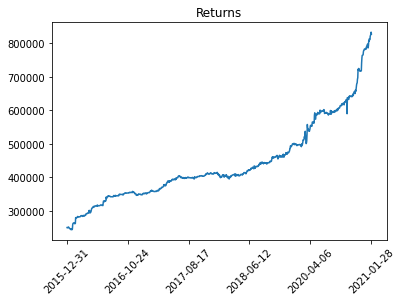

Returns: 231.1%
Sharpe Ratio: 2.55


In [15]:
# These are the optimal parameters with highest in-sample returns
trading_limits = {"Australia" : 2, "China" : 2, "Japan" : 2}
allocation = {"Australia" : 0.25, "China" : 0.35, "Japan" : 0.4}
# In-Sample
dates1, portfolio_values1, trade_records1, num_traded1, hp_dict1 = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2016-01-01", end_date = "2019-02-21")
dates2, portfolio_values2, trade_records2, num_traded2, hp_dict2 = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2020-02-23", end_date = "2021-01-31", cash = portfolio_values1[-1])
plt.title("Returns")
dates = dates1 + dates2[1:]
portfolio_values = portfolio_values1 + portfolio_values2[1:]
plot_returns(dates, portfolio_values)
#print("".join(trade_records[:11]))
ret = np.round(100*(portfolio_values[-1] - portfolio_values[0])/portfolio_values[0], 2)
print("Returns: {}%".format(ret))
print("Sharpe Ratio: {}".format(calc_sharpe(portfolio_values)))

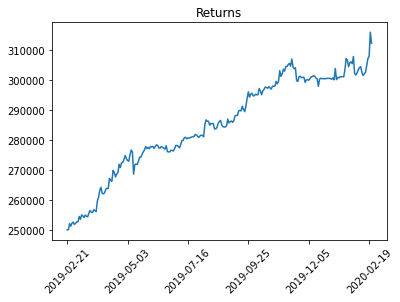

Returns: 24.92%
Sharpe Ratio: 2.85


In [16]:
# Out-Sample
dates, portfolio_values, trade_records, num_traded, hp_dict = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2019-02-22", end_date = "2020-02-21")
plt.title("Returns")
plot_returns(dates, portfolio_values)
#print("".join(trade_records[:11]))
ret = np.round(100*(portfolio_values[-1] - portfolio_values[0])/portfolio_values[0], 2)
print("Returns: {}%".format(ret))
print("Sharpe Ratio: {}".format(calc_sharpe(portfolio_values)))

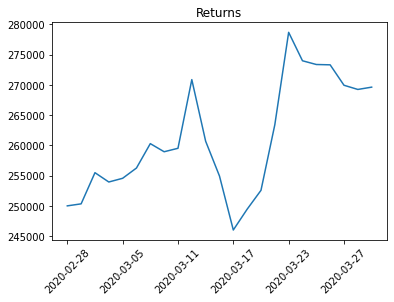

Returns: 7.85%
Sharpe Ratio: 2.56


In [17]:
# Stress-Testing
dates, portfolio_values, trade_records, num_traded, hp_dict = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2020-03-01", end_date = "2020-03-31")
plt.title("Returns")
plot_returns(dates, portfolio_values)
#print("".join(trade_records[:11]))
ret = np.round(100*(portfolio_values[-1] - portfolio_values[0])/portfolio_values[0], 2)
print("Returns: {}%".format(ret))
print("Sharpe Ratio: {}".format(calc_sharpe(portfolio_values)))

In [18]:
# Store the actual entries and exits we trade at
dates, portfolio_values, trade_records, num_traded, hp_dict = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2016-01-01", end_date = "2021-01-31")
df = pd.DataFrame(columns = ["country", "adr", "hp_entry", "actual_entry", "hp_exit", "actual_exit"])
for key in hp_dict:
    row = [*key, hp_dict[key]["entry"], np.mean(hp_dict[key]["actual_entries"]), hp_dict[key]["exit"], np.mean(hp_dict[key]["actual_exits"])]
    df.loc[len(df)] = row
df.to_csv("actual_hps.csv")